In [ ]:
import pickle
import numpy as np

from soar.preprocess import get_dataset, reformat_solutions_parquet
from soar.llm_utils import (
    get_number_of_solved_tasks_bis, 
    get_info,
    format_all_generation, 
    merge_results, 
    rm_untested_task
)
from soar.prompt import (
    get_solver_prompt, 
    prompt_wo_fewshot_v1_, 
    prompt_fewshot_v1,
    format_fewshot_examples,
    prompt_repair_sol_v1,
    get_repair_prompt
)

from soar.api import LLM_serv
from soar.sandbox.execute_code_less_safe import check_solutions



In [ ]:
path_soar = "...your_path/SOAR/" # path to SOAR repository
train_data, val_data, _ = get_dataset(data_path=path_soar,arc_2=False)
data2test = train_data
list_task_id_to_solve = list(train_data.keys())
# take subset for testing
list_task_id_to_solve = list_task_id_to_solve[:10]
data2test = {k: data2test[k] for k in list_task_id_to_solve}

/home/flowers/work/SOAR/arc-prize-2024/
/home/flowers/work/SOAR/arc-prize-2024/arc-agi_training_challenges.json


# init llm

In [ ]:
# downland a model from huggingface: https://huggingface.co/collections/julien31/soar-arc-6856d27681fce01d9af4c4a3
model_list = [
    "julien31/Soar-qwen-7b",
    "julien31/Soar-qwen-14b",
    "julien31/Soar-qwen-32b",
    "julien31/Soar-qwen-72b",
    "julien31/Soar-mistral-123b"
]

fp8 = True # need GPU with fp8 support, compute capability > 8.9 (e.g. H100)
gpu_mem = 0.9 # decrease if OOM
llm = LLM_serv("julien31/Soar-qwen-7b", model_len=30000,n_gpu=1, temperature=1,
                gpu_mem=gpu_mem, fp8=fp8, max_tokens=4096)


max_running_requests 0
schedule_conservativeness -1
schedule_conservativeness -1
max_running_requests 0
python -m sglang.launch_server --model-path /home/flowers/work/hf/Soar-qwen-7b --port 30024 --host 0.0.0.0 --tp 1 --context-length 30000 --random-seed 0 --mem-fraction-static 0.89 --quantization fp8 
[2025-06-23 16:21:04] server_args=ServerArgs(model_path='/home/flowers/work/hf/Soar-qwen-7b', tokenizer_path='/home/flowers/work/hf/Soar-qwen-7b', tokenizer_mode='auto', skip_tokenizer_init=False, load_format='auto', trust_remote_code=False, dtype='auto', kv_cache_dtype='auto', quantization='fp8', quantization_param_path=None, context_length=30000, device='cuda', served_model_name='/home/flowers/work/hf/Soar-qwen-7b', chat_template=None, completion_template=None, is_embedding=False, enable_multimodal=None, revision=None, impl='auto', host='0.0.0.0', port=30024, mem_fraction_static=0.89, max_running_requests=None, max_total_tokens=None, chunked_prefill_size=2048, max_prefill_tokens=16384,

/home/flowers/miniconda3/envs/sglang47/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm




                    NOTE: Typically, the server runs in a separate terminal.
                    In this notebook, we run the server and notebook code together, so their outputs are combined.
                    To improve clarity, the server logs are displayed in the original black color, while the notebook outputs are highlighted in blue.
                    We are running those notebooks in a CI parallel environment, so the throughput is not representative of the actual performance.
                    
[2025-06-23 16:21:35] INFO:     127.0.0.1:36546 - "GET /get_model_info HTTP/1.1" 200 OK
[2025-06-23 16:21:35] INFO:     127.0.0.1:36560 - "GET /v1/models HTTP/1.1" 200 OK


                    NOTE: Typically, the server runs in a separate terminal.
                    In this notebook, we run the server and notebook code together, so their outputs are combined.
                    To improve clarity, the server logs are displayed in the original black color, while the notebook out

In [ ]:
# load fewshot examples
use_fewshot = False
if use_fewshot:
    path_fewshot = path_soar+"soar/inference/train_solutions.pkl"
    with open(path_fewshot, "rb") as f:
        fewshot_solutions = merge_results(pickle.load(f))
        list_k_fewshot,list_fewshot_examples = format_fewshot_examples(fewshot_solutions,path_soar)

else:
    list_k_fewshot = []
    list_fewshot_examples = []



/home/flowers/work/SOAR/arc-prize-2024/
/home/flowers/work/SOAR/arc-prize-2024/arc-agi_training_challenges.json


In [7]:
# generate prompts for the tasks to solve 
prompts_formated = []
for key in list_task_id_to_solve:
    task2solve = data2test[key]
    if use_fewshot:
        id_fs = np.random.choice(len(list_k_fewshot))
        if list_k_fewshot[id_fs] == key:
            id_fs = (id_fs + 1) % len(list_k_fewshot)
        list_fewshot_examples = [list_fewshot_examples[id_fs]]
        prompt_solver = prompt_wo_fewshot_v1_
    else:
        list_fewshot_examples = []
        prompt_solver = prompt_fewshot_v1

    prompt_formated = get_solver_prompt(
        task2solve,
        list_fewshot_examples,
        prompt_solver=prompt_solver,
    )
    prompts_formated.append(prompt_formated)        


In [9]:
k = 5
results = llm.generate(prompts_formated,n=k)

# format results
dict_response = format_all_generation(results, list_task_id_to_solve, use_vllm_generate=False)

# execute solutions
dict_response = check_solutions(dict_response, data2test)
dict_response = rm_untested_task(dict_response)
n_solved = get_number_of_solved_tasks_bis(dict_response)["test_task_solved_with_all_train_correct"]
print(f"Number of solved tasks: {n_solved} / {len(list_task_id_to_solve)}")



[2025-06-23 16:23:12] Prefill batch. #new-seq: 1, #new-token: 719, #cached-token: 34, token usage: 0.00, #running-req: 0, #queue-req: 0
[2025-06-23 16:23:12] Prefill batch. #new-seq: 2, #new-token: 2048, #cached-token: 605, token usage: 0.00, #running-req: 1, #queue-req: 7
[2025-06-23 16:23:13] Prefill batch. #new-seq: 1, #new-token: 2048, #cached-token: 0, token usage: 0.02, #running-req: 2, #queue-req: 12
[2025-06-23 16:23:13] Prefill batch. #new-seq: 2, #new-token: 2048, #cached-token: 301, token usage: 0.03, #running-req: 2, #queue-req: 11
[2025-06-23 16:23:13] Prefill batch. #new-seq: 2, #new-token: 2048, #cached-token: 301, token usage: 0.06, #running-req: 3, #queue-req: 15
[2025-06-23 16:23:13] Prefill batch. #new-seq: 1, #new-token: 2048, #cached-token: 0, token usage: 0.03, #running-req: 4, #queue-req: 15
[2025-06-23 16:23:14] Prefill batch. #new-seq: 1, #new-token: 2048, #cached-token: 0, token usage: 0.04, #running-req: 4, #queue-req: 20
[2025-06-23 16:23:14] Prefill batch. 

## refinement

In [ ]:
prompt_repair = prompt_repair_sol_v1 
# prompt formatting
list_program_2_refine = []
list_task_id_repair = []
for k,v in dict_response.items():
    if len(v) > 0:
        list_program_2_refine.append([np.random.choice(v)])
        list_task_id_repair.append(k)


list_prompt=[]
for id in range(len(list_program_2_refine)):
    prompt = get_repair_prompt(task2solve = data2test[list_task_id_repair[id]],
                            list_previous_response = list_program_2_refine[id],
                            prompt_solver = prompt_repair,
                            grid_display_mode="numpy",
                            max_example = -1)
    list_prompt.append(prompt)


In [23]:
results = llm.generate(list_prompt, n=4)
dict_response = format_all_generation(results, list_task_id_repair, use_vllm_generate=False, use_cot=False)
dict_response_refined = check_solutions(dict_response,data2test, keep_only_correct_results=False)
n_solved = get_number_of_solved_tasks_bis(dict_response)["test_task_solved_with_all_train_correct"]
print(f"Number of solved tasks: {n_solved} / {len(list_task_id_to_solve)}")


[2025-06-23 16:35:05] Prefill batch. #new-seq: 1, #new-token: 2048, #cached-token: 54, token usage: 0.00, #running-req: 0, #queue-req: 0
[2025-06-23 16:35:05] Prefill batch. #new-seq: 1, #new-token: 2048, #cached-token: 0, token usage: 0.02, #running-req: 0, #queue-req: 2
[2025-06-23 16:35:06] Prefill batch. #new-seq: 2, #new-token: 2048, #cached-token: 272, token usage: 0.04, #running-req: 0, #queue-req: 8
[2025-06-23 16:35:06] Prefill batch. #new-seq: 3, #new-token: 2048, #cached-token: 547, token usage: 0.06, #running-req: 1, #queue-req: 6
[2025-06-23 16:35:06] Prefill batch. #new-seq: 2, #new-token: 2048, #cached-token: 272, token usage: 0.03, #running-req: 3, #queue-req: 5
[2025-06-23 16:35:07] Prefill batch. #new-seq: 1, #new-token: 2048, #cached-token: 0, token usage: 0.02, #running-req: 4, #queue-req: 9
[2025-06-23 16:35:07] Prefill batch. #new-seq: 2, #new-token: 2048, #cached-token: 272, token usage: 0.03, #running-req: 4, #queue-req: 16
[2025-06-23 16:35:07] Prefill batch. #

# visualization

Task ID: 00d62c1b
----------------------------------------------------------------------------------------------------------------------------------------------------------------


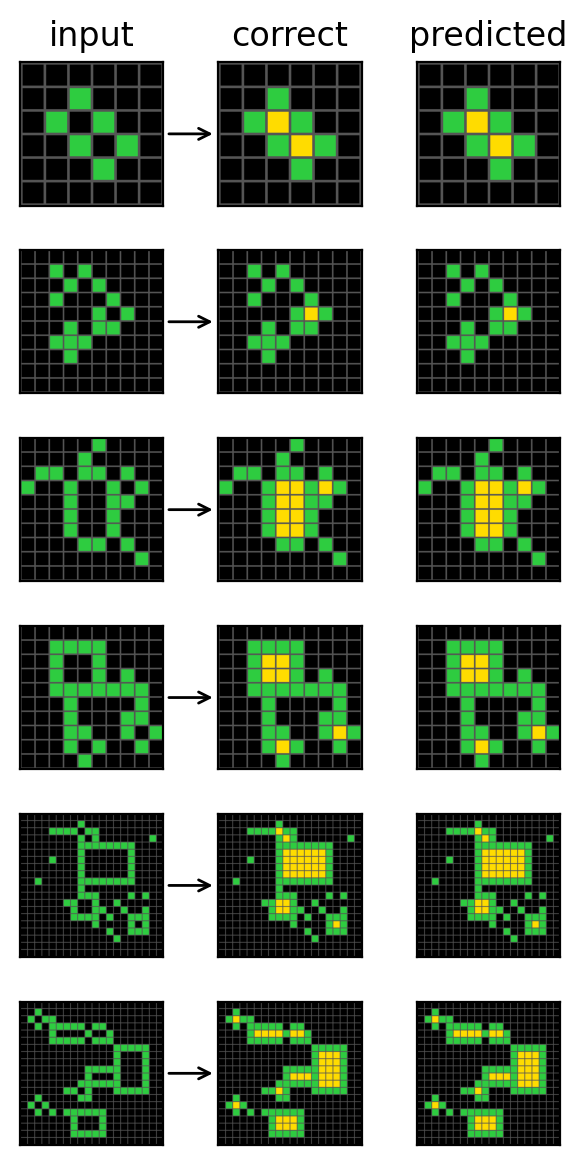

def transform(grid_lst: list[list[int]]) -> list[list[int]]:

    def flood_fill(grid, r, c, color, target_color):
        stack = [(r, c)]
        while stack:
            x, y = stack.pop()
            if 0 <= x < len(grid) and 0 <= y < len(grid[0]) and (grid[x][y] == color):
                grid[x][y] = target_color
                stack.append((x - 1, y))
                stack.append((x + 1, y))
                stack.append((x, y - 1))
                stack.append((x, y + 1))

    def is_enclosed(grid, r, c):
        stack = [(r, c)]
        visited = set()
        touches_boundary = False
        while stack:
            x, y = stack.pop()
            if (x, y) in visited:
                continue
            visited.add((x, y))
            if x == 0 or x == len(grid) - 1 or y == 0 or (y == len(grid[0]) - 1):
                touches_boundary = True
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nx, ny = (x + dx, y + dy)
                if 0 <= nx < l

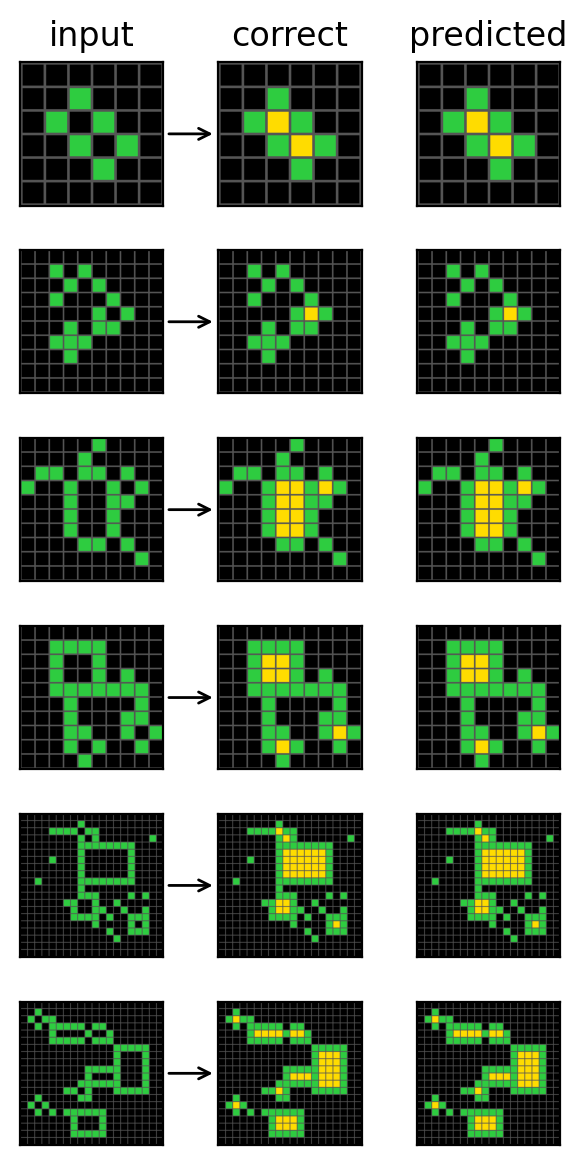

def transform(grid: list[list[int]]) -> list[list[int]]:

    def is_enclosed(grid, x, y):
        if grid[x][y] != 0:
            return False
        visited = set()
        stack = [(x, y)]
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        is_enclosed_by_3s = True
        while stack:
            cx, cy = stack.pop()
            if (cx, cy) in visited:
                continue
            visited.add((cx, cy))
            for dx, dy in directions:
                nx, ny = (cx + dx, cy + dy)
                if not (0 <= nx < len(grid) and 0 <= ny < len(grid[0])):
                    is_enclosed_by_3s = False
                elif grid[nx][ny] == 0:
                    stack.append((nx, ny))
                elif grid[nx][ny] != 3:
                    is_enclosed_by_3s = False
        return is_enclosed_by_3s

    def fill_with_yellow(grid, x, y):
        if grid[x][y] != 0:
            return
        stack = [(x, y)]
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

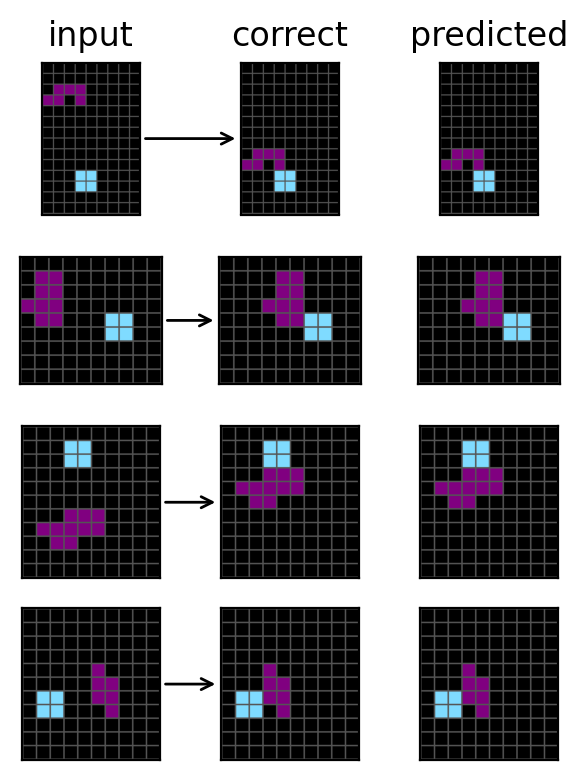

def transform(grid_lst: list[list[int]]) -> list[list[int]]:
    grid = [row[:] for row in grid_lst]
    red_color = 2
    purple_color = 8
    red_positions = [(i, j) for i, row in enumerate(grid) for j, cell in enumerate(row) if cell == red_color]
    purple_positions = [(i, j) for i, row in enumerate(grid) for j, cell in enumerate(row) if cell == purple_color]
    if not red_positions or not purple_positions:
        return grid
    red_min_i = min(red_positions, key=lambda x: x[0])[0]
    red_max_i = max(red_positions, key=lambda x: x[0])[0]
    red_min_j = min(red_positions, key=lambda x: x[1])[1]
    red_max_j = max(red_positions, key=lambda x: x[1])[1]
    purple_min_i = min(purple_positions, key=lambda x: x[0])[0]
    purple_max_i = max(purple_positions, key=lambda x: x[0])[0]
    purple_min_j = min(purple_positions, key=lambda x: x[1])[1]
    purple_max_j = max(purple_positions, key=lambda x: x[1])[1]
    move_i = 0
    move_j = 0
    if red_max_i < purple_min_i:
        move_

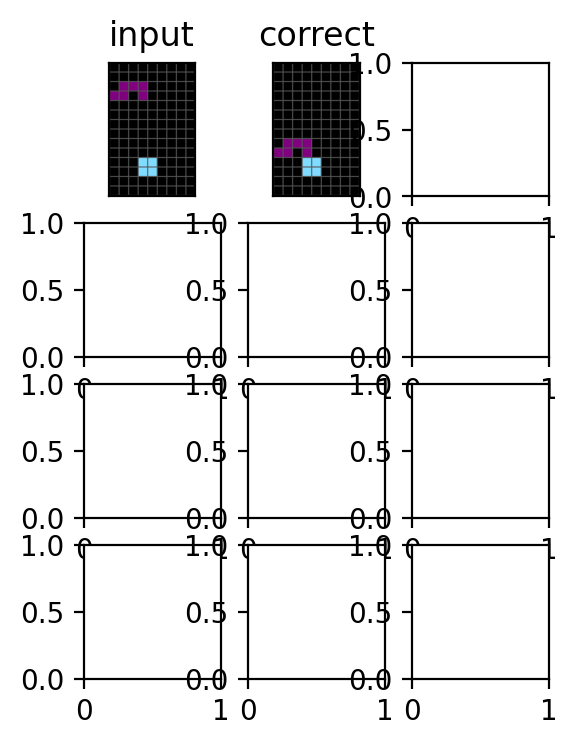

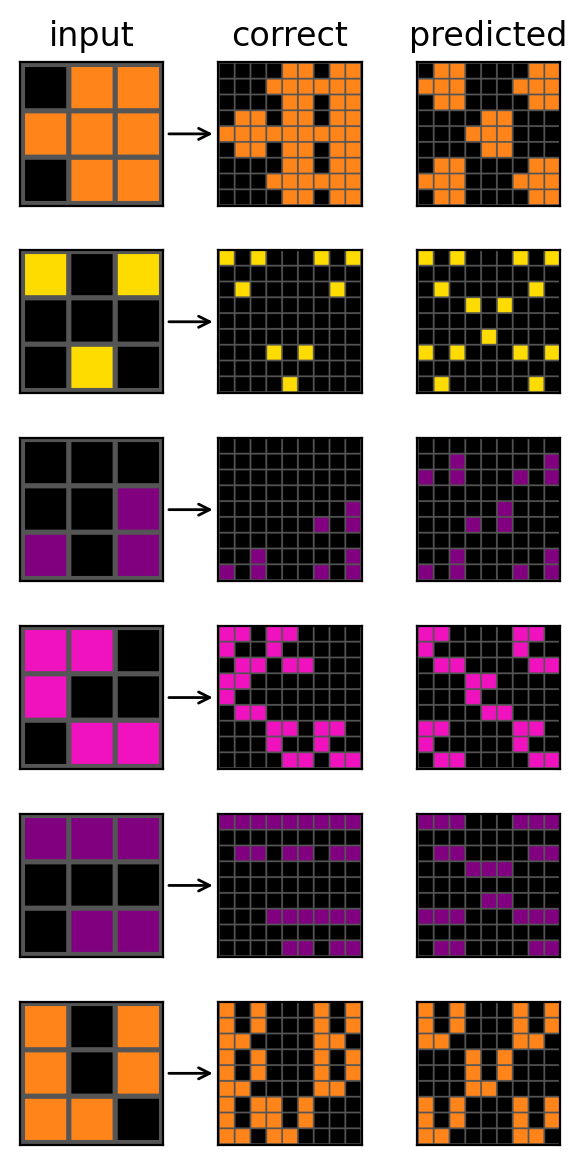

def transform(grid_lst: list[list[int]]) -> list[list[int]]:

    def expand_grid(grid):
        new_grid = [[0 for _ in range(9)] for _ in range(9)]
        for i in range(3):
            for j in range(3):
                new_grid[i][j] = grid[i][j]
                new_grid[i][j + 6] = grid[i][j]
                new_grid[i + 6][j] = grid[i][j]
                new_grid[i + 6][j + 6] = grid[i][j]
        for i in range(3):
            for j in range(3):
                if grid[i][j] != 0:
                    new_grid[i + 3][j + 3] = grid[i][j]
                    new_grid[i + 3][j + 6 - 3] = grid[i][j]
                    new_grid[i + 6 - 3][j + 3] = grid[i][j]
                    new_grid[i + 6 - 3][j + 6 - 3] = grid[i][j]
        return new_grid
    return expand_grid(grid_lst)
--------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------


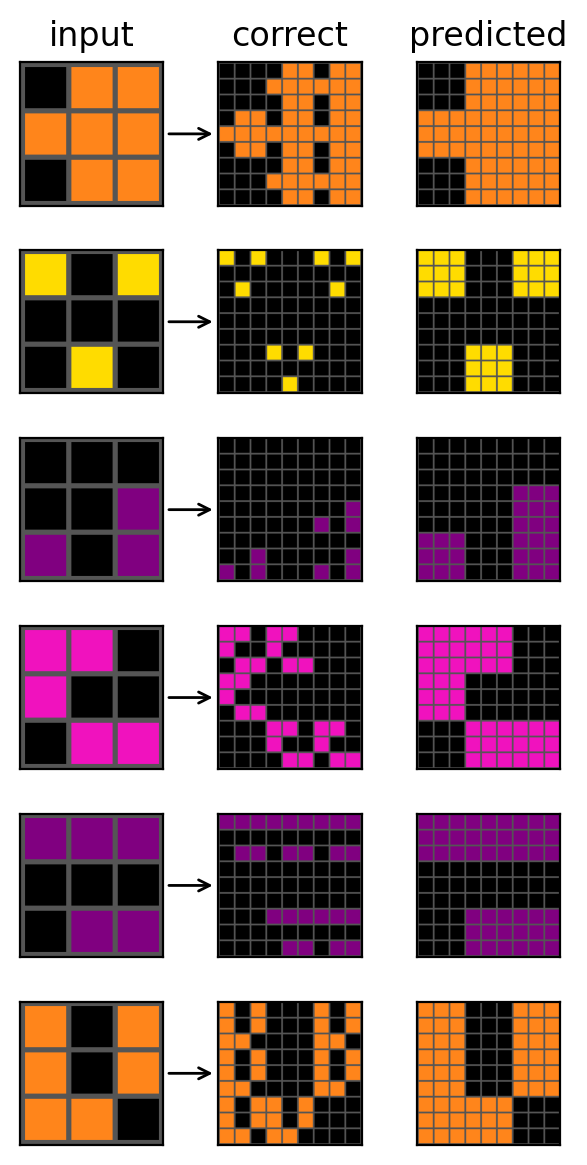

def transform(grid_lst: list[list[int]]) -> list[list[int]]:
    height = len(grid_lst)
    width = len(grid_lst[0])
    new_height = height * 3
    new_width = width * 3
    new_grid = [[0 for _ in range(new_width)] for _ in range(new_height)]
    for i in range(height):
        for j in range(width):
            value = grid_lst[i][j]
            for k in range(3):
                for l in range(3):
                    if i * 3 + k < new_height and j * 3 + l < new_width:
                        if value != 0 or (k == 1 and l == 1):
                            new_grid[i * 3 + k][j * 3 + l] = value
    return new_grid
--------------------
Task ID: 05269061
----------------------------------------------------------------------------------------------------------------------------------------------------------------


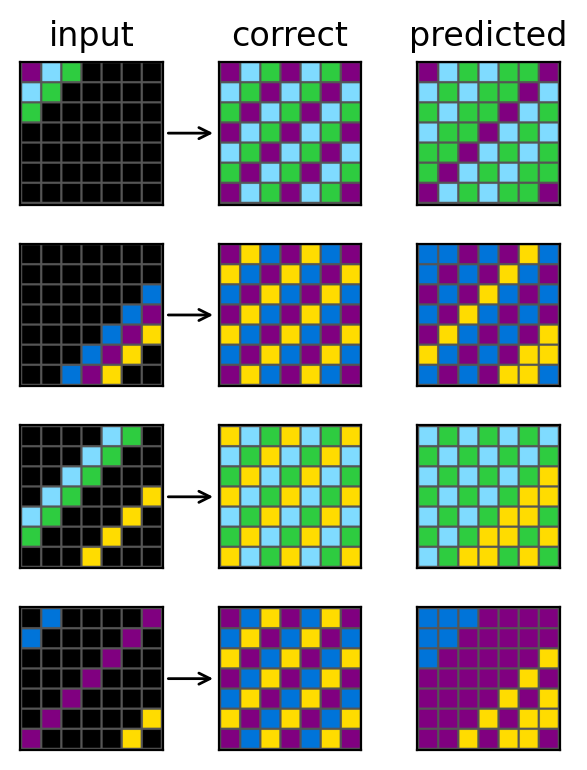

def transform(grid_lst: list[list[int]]) -> list[list[int]]:
    grid = [row[:] for row in grid_lst]
    rows, cols = (len(grid), len(grid[0]))
    start_positions = []
    for i in range(rows):
        for j in range(cols):
            if grid[i][j] != 0:
                start_positions.append((i, j))
    if not start_positions:
        return grid
    start_positions.sort(key=lambda x: (x[0], x[1]))
    pattern = []
    for i, j in start_positions:
        pattern.append(grid[i][j])
    pattern_length = len(pattern)
    for i in range(rows):
        for j in range(cols):
            if grid[i][j] == 0:
                grid[i][j] = pattern[(i + j) % pattern_length]
    return grid
--------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------


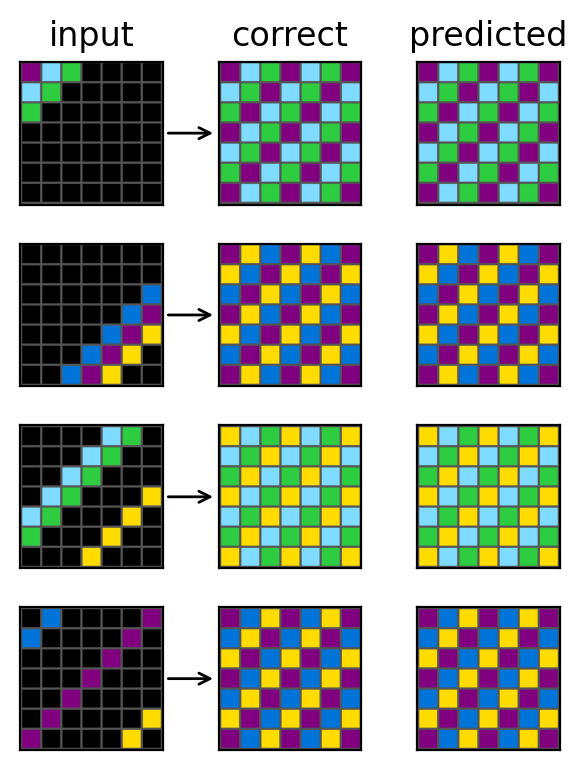

def transform(grid):
    rows = len(grid)
    cols = len(grid[0])
    pattern = []
    for j in range(cols):
        if grid[rows - 1][j] != 0:
            pattern.append(grid[rows - 1][j])
        if grid[0][j] != 0 and grid[0][j] not in pattern:
            pattern.append(grid[0][j])
    if not pattern:
        pattern = [2, 4, 1]
    if pattern == [1, 2, 4] or pattern == [4, 1, 2]:
        pattern = [2, 4, 1]
    pattern_length = len(pattern)
    for row in range(rows):
        for col in range(cols):
            index = (row + col) % pattern_length
            grid[row][col] = pattern[index]
    return grid
--------------------
Task ID: 00d62c1b
----------------------------------------------------------------------------------------------------------------------------------------------------------------


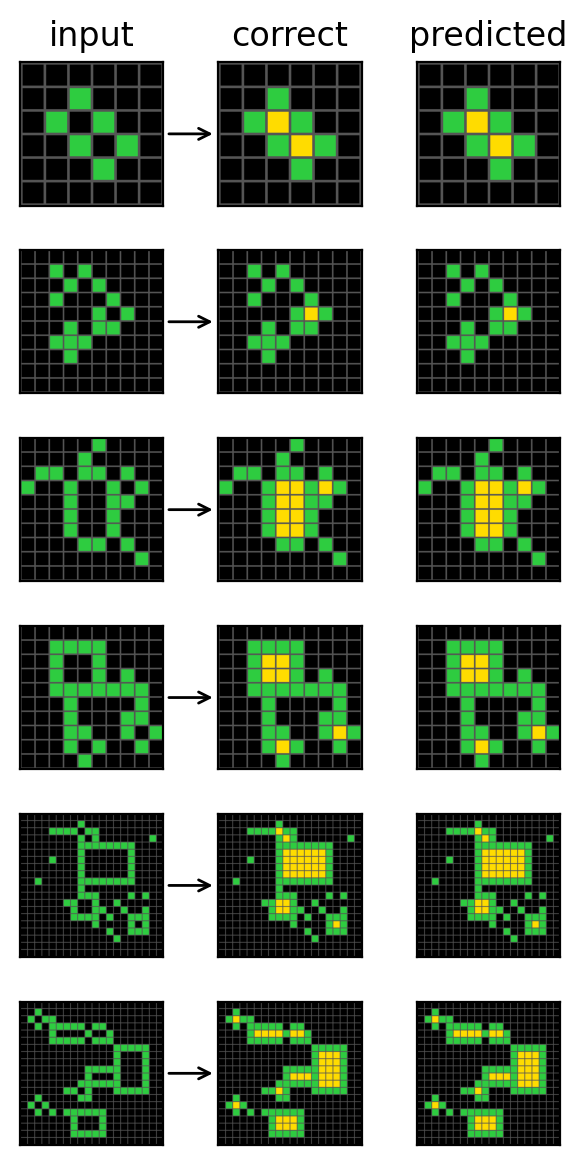

def transform(grid_lst: list[list[int]]) -> list[list[int]]:

    def flood_fill(grid, r, c, color, target_color):
        stack = [(r, c)]
        while stack:
            x, y = stack.pop()
            if 0 <= x < len(grid) and 0 <= y < len(grid[0]) and (grid[x][y] == color):
                grid[x][y] = target_color
                stack.append((x - 1, y))
                stack.append((x + 1, y))
                stack.append((x, y - 1))
                stack.append((x, y + 1))

    def is_enclosed(grid, r, c):
        stack = [(r, c)]
        visited = set()
        touches_boundary = False
        while stack:
            x, y = stack.pop()
            if (x, y) in visited:
                continue
            visited.add((x, y))
            if x == 0 or x == len(grid) - 1 or y == 0 or (y == len(grid[0]) - 1):
                touches_boundary = True
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nx, ny = (x + dx, y + dy)
                if 0 <= nx < l

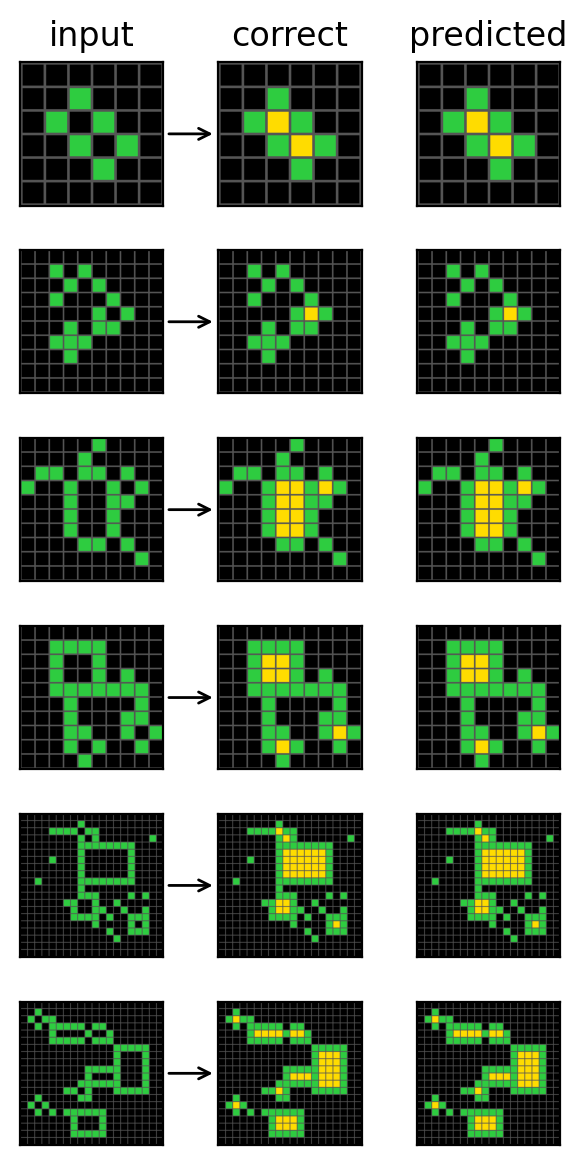

def transform(grid: list[list[int]]) -> list[list[int]]:

    def is_enclosed(grid, x, y):
        if grid[x][y] != 0:
            return False
        visited = set()
        stack = [(x, y)]
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        is_enclosed_by_3s = True
        while stack:
            cx, cy = stack.pop()
            if (cx, cy) in visited:
                continue
            visited.add((cx, cy))
            for dx, dy in directions:
                nx, ny = (cx + dx, cy + dy)
                if not (0 <= nx < len(grid) and 0 <= ny < len(grid[0])):
                    is_enclosed_by_3s = False
                elif grid[nx][ny] == 0:
                    stack.append((nx, ny))
                elif grid[nx][ny] != 3:
                    is_enclosed_by_3s = False
        return is_enclosed_by_3s

    def fill_with_yellow(grid, x, y):
        if grid[x][y] != 0:
            return
        stack = [(x, y)]
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

In [ ]:
from soar.render import show_train_test_gt

for k in np.random.choice(list(dict_response_refined.keys()),size=5):
    print("=="*20)
    print(f"Task ID: {k}")
    print("=="*20)
    dic_resp_k=dict_response_refined[k]
    list_unique_code=[]
    list_resp=[]
    task = data2test[k]
       
            
    for resp in dic_resp_k[:2]:
        try:
            show_train_test_gt(resp,task)
        except Exception as e:
            print(f"Error displaying task {k}: {e}")
            continue
        print(resp['code'])
        print("-"*20)

In [ ]:
# terminate the SGLang engine

llm.terminate()